In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pickle

Загрузим DataFrame, уберем ненужные столбцы (ID и пустой)

In [2]:
df = pd.read_csv('data.csv')
df = df.drop('Unnamed: 32', axis=1).drop("id", axis=1)

df.head()
# malignant - "bad"
# benign - "good"

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Убедимся, что в датасете нет ячеек с NaN

In [3]:
df.isnull().values.any()

False

Посмотрим типы данных, наименования столбцов

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

Немного графиков

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

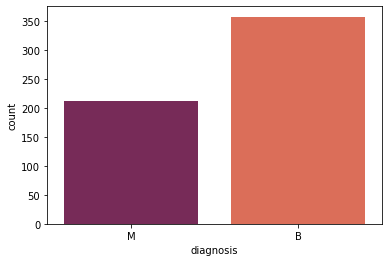

In [5]:
sns.countplot(x=df['diagnosis'],palette='rocket')

<AxesSubplot:xlabel='radius_mean', ylabel='texture_mean'>

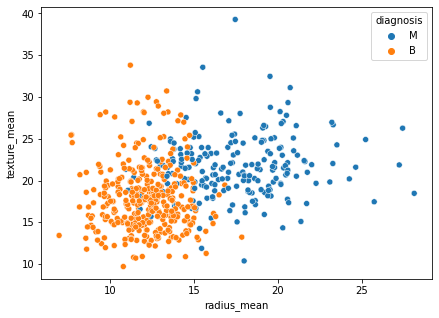

In [6]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df,x='radius_mean',y='texture_mean',hue='diagnosis')

<AxesSubplot:title={'center':'CORRELATION HEATMAP'}>

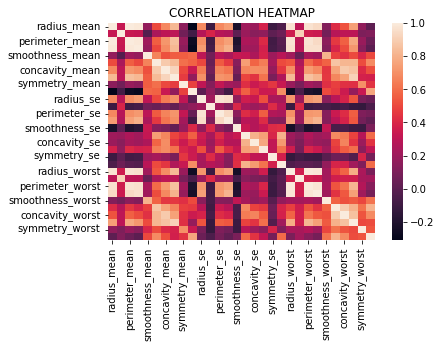

In [7]:
plt.title("CORRELATION HEATMAP")
sns.heatmap(df.corr())

Преобразуем Malignant и Benign в числа

In [3]:
# M - 1
# B - 0

print("B:", df.iloc[20]['diagnosis'])
print("M:", df.iloc[0]['diagnosis'])

le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])

print("B:", df.iloc[20]['diagnosis'])
print("M:", df.iloc[0]['diagnosis'])

B: B
M: M
B: 0.0
M: 1.0


In [4]:
ss = StandardScaler()
cols = list(df)[1:]
df[cols] = ss.fit_transform(df[cols])

Разделяем выборку 9датасет) на 3 части

In [5]:
#street magic
train, test, validate = np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])

Отделяем "игреки" от "иксов"

In [6]:
separate = lambda x: (x['diagnosis'], x.drop("diagnosis",axis=1))

y_train, X_train = separate(train)
y_validate, X_validate = separate(validate)
y_test, X_test = separate(test)

y_full, X_full = separate(df)

Создаем, модель NN. Подбираем для нее параметры

In [7]:
rfc = RandomForestClassifier(random_state=0)
parameters = {
    'n_estimators': list(range(100,500,100)),
    'max_depth': list(range(2,10)),
    
}
cvgrid = GridSearchCV(estimator=rfc, param_grid=parameters,n_jobs=-1,verbose=3) 
cvgrid.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [100, 200, 300, 400]},
             verbose=3)

Выбираем модель с лучшим показателем

In [8]:
rfc_model = cvgrid.best_estimator_

Посмотрим процент "точных" предсказаний модели

In [9]:
predicted = rfc_model.predict(X_validate)
aim=list(y_validate)
c=0
for i in range(len(aim)):
    if aim[i]==predicted[i]:
        c+=1
print(f"Accuracy:\t{round(100*c/len(aim), 2)}%\nMAE:\t\t{round(100*mean_absolute_error(y_validate, predicted), 2)}%")

Accuracy:	93.86%
MAE:		6.14%


In [12]:
model_fin = rfc_model # final model
with open("model.pckl", 'wb') as file:
    file.write(pickle.dumps(model_fin))